In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import pandas as pd
from pyspark.sql import *
import numpy as np
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName('Data_model').getOrCreate()
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics

### import data source

In [2]:
normalizer_df = spark.read.csv('/home/ubuntu/BDAS_yang124/Datasets/normalizer_df_pandas.csv',inferSchema=True,header=True)
normalizer_df.show(5)
normalizer_df.printSchema()
normalizer_df.describe().show()

+---+------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|_c0|PrivateIndex|             Apps|           Accept|           Enroll|           Expend|       F_Undergrad|       P_Undergrad|         Outstate|       Room_Board|         S_F_Ratio|       perc_alumni|
+---+------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|  0|         0.0|7.415175109613295|7.117205503164344|6.582025138892826|8.859647499714997|7.9676267393338165|6.2878585601617845|8.914760527397261|8.101980731853192|2.9496883350525844|2.5649493574615367|
|  1|         0.0|7.690286020676768|7.562681246721884|6.240275845170769|9.261793653565098| 7.895063498091573| 7.113142108707088|9.415808631610384|8.771990436532242| 2.580216829592325| 2.83

### Obtain experimental data

In [3]:
inputCols=['Apps',
 'Accept',
 'Enroll',
 'Expend',           
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'S_F_Ratio',
 'perc_alumni']
assembler = VectorAssembler(
  inputCols=inputCols,
outputCol="features")
final_data_all = assembler.transform(normalizer_df)
final_data_all.show(5)

final_data = final_data_all.selectExpr("features","`PrivateIndex` as label")
final_data.show(5)

+---+------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+--------------------+
|_c0|PrivateIndex|             Apps|           Accept|           Enroll|           Expend|       F_Undergrad|       P_Undergrad|         Outstate|       Room_Board|         S_F_Ratio|       perc_alumni|            features|
+---+------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+--------------------+
|  0|         0.0|7.415175109613295|7.117205503164344|6.582025138892826|8.859647499714997|7.9676267393338165|6.2878585601617845|8.914760527397261|8.101980731853192|2.9496883350525844|2.5649493574615367|[7.41517510961329...|
|  1|         0.0|7.690286020676768|7.562681246721884|6.240275845170769|9.261793653565098| 7.89506349809

### Segmentation data, used to select the best model, to obtain the best parameters

In [4]:
from pyspark.ml.feature import VectorIndexer
train_data,test_data = final_data.randomSplit([0.7,0.3])
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(train_data)

featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures',
                               maxCategories=2).fit(train_data)

### Build the original model and get its model score.

In [5]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
nb = NaiveBayes()
lr_original_model=lr.fit(train_data)
rfc_original_model=rfc.fit(train_data)
dtc_original_model=dtc.fit(train_data)
nb_original_model=nb.fit(train_data)
lr_original_predictions=lr_original_model.transform(test_data)
rfc_original_predictions=rfc_original_model.transform(test_data)
dtc_original_predictions=dtc_original_model.transform(test_data)
nb_original_predictions=nb_original_model.transform(test_data)

from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_binary_eval = BinaryClassificationEvaluator()

print("DTC")
print(my_binary_eval.evaluate(dtc_original_predictions))
print("RFC")
print(my_binary_eval.evaluate(rfc_original_predictions))
print("LR")
print(my_binary_eval.evaluate(lr_original_predictions))
print("NB")
print(my_binary_eval.evaluate(nb_original_predictions))

DTC
0.9599025597401594
RFC
0.9821230634392807
LR
0.9798159461758568
NB
0.17853736498852885


### Obtain the accuracy of the original model in predicting experimental data.

In [6]:

acc_evaluator = MulticlassClassificationEvaluator( predictionCol="prediction", metricName="accuracy")
dtc_orignal_acc = acc_evaluator.evaluate(dtc_original_predictions)
rfc_orignal_acc = acc_evaluator.evaluate(rfc_original_predictions)
lr_orignal_acc = acc_evaluator.evaluate(lr_original_predictions)
nb_orignal_acc = acc_evaluator.evaluate(nb_original_predictions)

print('-'*40)
print('Decision tree has an accuracy of: {0:2.2f}%'.format(dtc_orignal_acc*100))
print('-'*40)
print('Random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_orignal_acc*100))
print('-'*40)
print(' LR has an accuracy of: {0:2.2f}%'.format(lr_orignal_acc*100))
print('-'*40)
print(' NB has an accuracy of: {0:2.2f}%'.format(nb_orignal_acc*100))

----------------------------------------
Decision tree has an accuracy of: 93.91%
----------------------------------------
Random forest ensemble has an accuracy of: 94.42%
----------------------------------------
 LR has an accuracy of: 94.92%
----------------------------------------
 NB has an accuracy of: 88.32%


###  Define methods for validation and drawing
- evaluate : method for get AUROC AUPR f1_score recall precision.
- drawcrue :draw how picture. 
- CurveMetrics : method for get PR and ROC curve. 

In [7]:
def evaluate(predictionAndLabels):
    log = {}

    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)    
    print("Area under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    log['precision'] = "%s" % metrics.precision()
    log['recall'] = "%s" % metrics.recall()
    log['F1 Measure'] = "%s" % metrics.fMeasure()
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % (log['precision'], log['recall'], log['F1 Measure']))

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label, 
                                                           beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s" % (label, log[label]['precision'], 
                                                                              log[label]['recall'], log[label]['F1 Measure']))

    return log

def drawcrue(model_name,roc,recall,precision,AUROC,AUPR):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(recall, precision, 'k')
    plt.title(model_name + ' PR curve')
    plt.plot([(0, 0), (1, 1)], 'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 01.01])
    plt.text(0.5,0.1,'Area under PR = '+ AUPR,bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
    plt.ylabel('Precision')
    plt.xlabel('Recall')

    plt.subplot(1,2,2)
    
    x_val = [x[0] for x in roc]
    y_val = [x[1] for x in roc]
    plt.title(model_name + ' ROC curve')
    plt.xlabel('False posibality rate')
    plt.ylabel('True posibality rate')
    plt.plot(x_val, y_val)
    plt.text(0.5,0.1,'Area under ROC = '+ AUROC,bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
    plt.plot([(0,0),(1,1)],'r--')
    plt.show()

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)
    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points
    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)  



### The original model was graded and analyzed graphically

LR model metrics
Area under ROC = 0.979816
Area under PR = 0.974929
[[183.  10.]
 [ 10. 191.]]
[Overall]	precision = 0.949238578680203 | recall = 0.949238578680203 | F1 Measure = 0.949238578680203


/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:237: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")
/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:249: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")
/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:262: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")


[Class 0.0]	precision = 0.9481865284974094 | recall = 0.9481865284974094 | F1 Measure = 0.9481865284974094
[Class 1.0]	precision = 0.9502487562189055 | recall = 0.9502487562189055 | F1 Measure = 0.9502487562189055


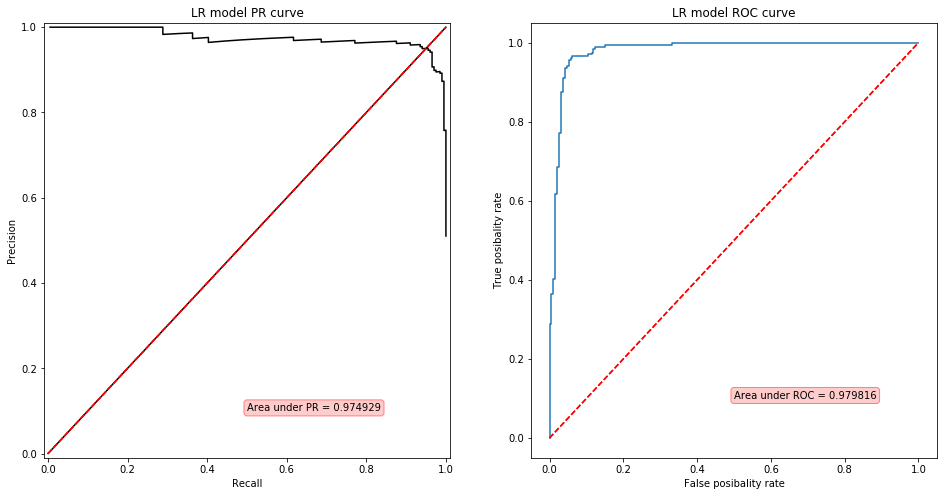

DTC model metrics
Area under ROC = 0.959903
Area under PR = 0.968066
[[176.  17.]
 [  7. 194.]]
[Overall]	precision = 0.9390862944162437 | recall = 0.9390862944162437 | F1 Measure = 0.9390862944162437
[Class 0.0]	precision = 0.9617486338797814 | recall = 0.9119170984455959 | F1 Measure = 0.9361702127659576
[Class 1.0]	precision = 0.919431279620853 | recall = 0.9651741293532339 | F1 Measure = 0.941747572815534


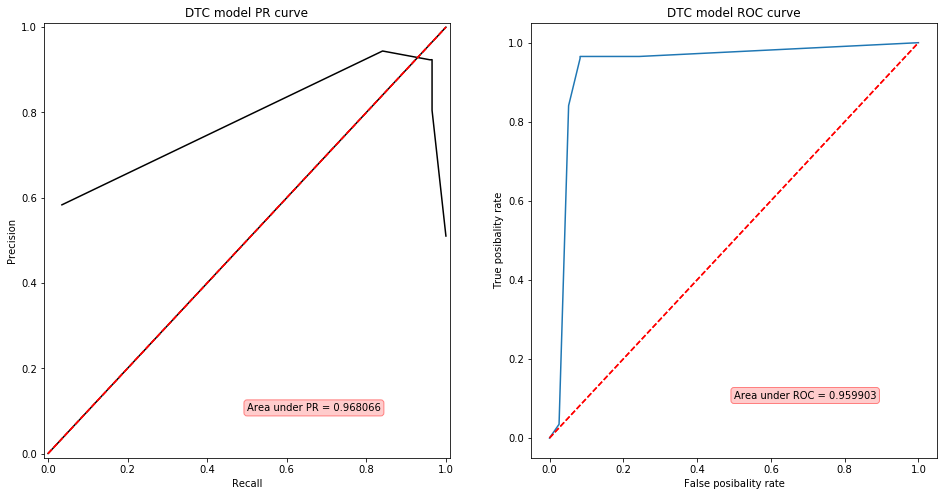

RF model metrics
Area under ROC = 0.982123
Area under PR = 0.978249
[[181.  12.]
 [ 10. 191.]]
[Overall]	precision = 0.9441624365482234 | recall = 0.9441624365482234 | F1 Measure = 0.9441624365482234
[Class 0.0]	precision = 0.9476439790575916 | recall = 0.9378238341968912 | F1 Measure = 0.9427083333333334
[Class 1.0]	precision = 0.9408866995073891 | recall = 0.9502487562189055 | F1 Measure = 0.9455445544554455


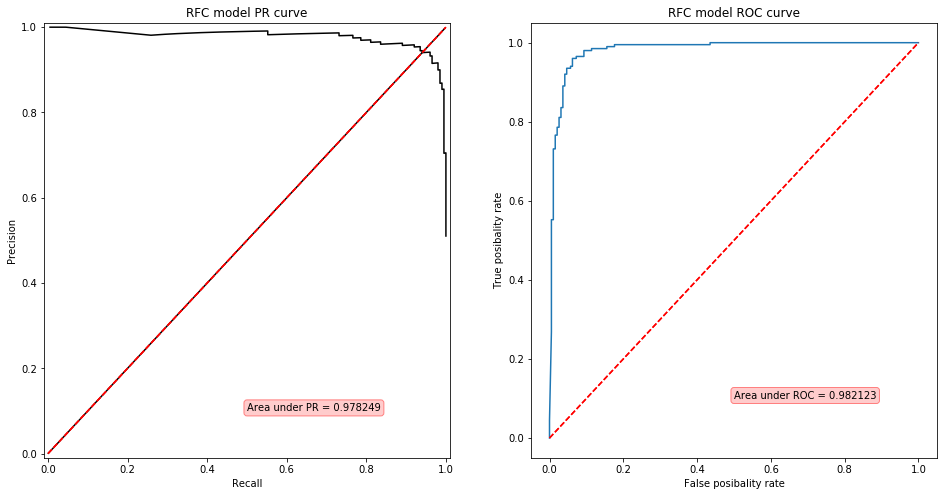

NB model metrics
Area under ROC = 0.178537
Area under PR = 0.348647
[[167.  26.]
 [ 20. 181.]]
[Overall]	precision = 0.883248730964467 | recall = 0.883248730964467 | F1 Measure = 0.883248730964467
[Class 0.0]	precision = 0.893048128342246 | recall = 0.8652849740932642 | F1 Measure = 0.8789473684210526
[Class 1.0]	precision = 0.8743961352657005 | recall = 0.900497512437811 | F1 Measure = 0.8872549019607843


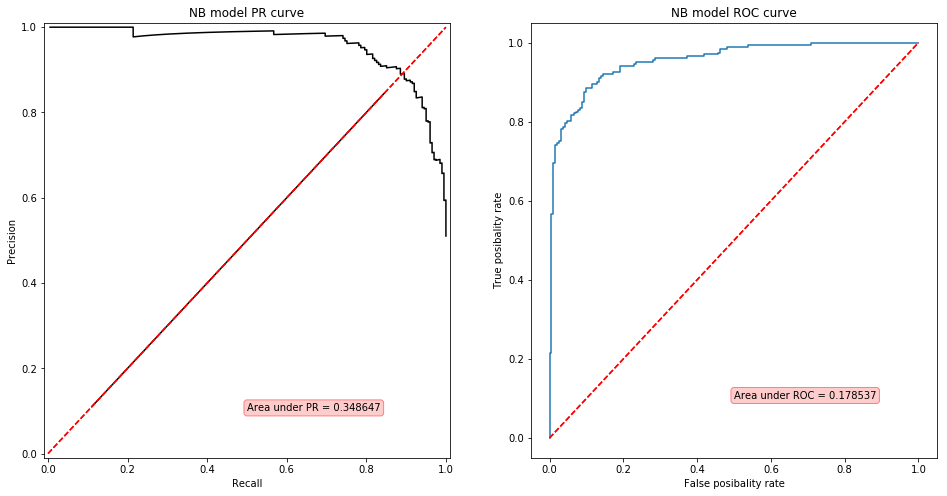

In [8]:
print("LR model metrics")
lr_log = evaluate(lr_original_predictions)

lr_preds = lr_original_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
lr_roc = CurveMetrics(lr_preds).get_curve('roc')
lr_metrics = CurveMetrics(lr_preds)
lr_f1_score = lr_metrics.get_curve('fMeasureByThreshold')
lr_precision = lr_metrics.get_curve('precisionByThreshold')
lr_recall = lr_metrics.get_curve('recallByThreshold')
lr_under_roc = lr_log['AUROC']
lr_under_pr = lr_log['AUPR']
drawcrue("LR model",lr_roc,lr_recall,lr_precision,lr_under_roc,lr_under_pr)

print("DTC model metrics")
dtc_log = evaluate(dtc_original_predictions)

dtc_preds = dtc_original_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
dtc_roc = CurveMetrics(dtc_preds).get_curve('roc')
dtc_metrics = CurveMetrics(dtc_preds)
dtc_f1_score = dtc_metrics.get_curve('fMeasureByThreshold')
dtc_precision = dtc_metrics.get_curve('precisionByThreshold')
dtc_recall = dtc_metrics.get_curve('recallByThreshold')

dtc_under_roc = dtc_log['AUROC']
dtc_under_pr = dtc_log['AUPR']
drawcrue("DTC model",dtc_roc,dtc_recall,dtc_precision,dtc_under_roc,dtc_under_pr)

print("RF model metrics")
rfc_log = evaluate(rfc_original_predictions)

rfc_preds = rfc_original_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rfc_roc = CurveMetrics(rfc_preds).get_curve('roc')
rfc_metrics = CurveMetrics(rfc_preds)
rfc_f1_score = rfc_metrics.get_curve('fMeasureByThreshold')
rfc_precision = rfc_metrics.get_curve('precisionByThreshold')
rfc_recall = rfc_metrics.get_curve('recallByThreshold')

rfc_under_roc = rfc_log['AUROC']
rfc_under_pr = rfc_log['AUPR']
drawcrue("RFC model",rfc_roc,rfc_recall,rfc_precision,rfc_under_roc,rfc_under_pr)
print("NB model metrics")
nb_log = evaluate(nb_original_predictions)

nb_preds = nb_original_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
nb_roc = CurveMetrics(nb_preds).get_curve('roc')
nb_metrics = CurveMetrics(nb_preds)
nb_f1_score = nb_metrics.get_curve('fMeasureByThreshold')
nb_precision = nb_metrics.get_curve('precisionByThreshold')
nb_recall = nb_metrics.get_curve('recallByThreshold')

nb_under_roc = nb_log['AUROC']
nb_under_pr = nb_log['AUPR']
drawcrue("NB model",nb_roc,nb_recall,nb_precision,nb_under_roc,nb_under_pr)

### Select the best parameters of the model and build the model.

#### LR model get best parameters and best model

In [9]:
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[labelIndexer,featureIndexer,lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

lr_best_model = crossval.fit(train_data)
params = lr_best_model.getEstimatorParamMaps()
avgMetrics = lr_best_model.avgMetrics
all_params = list(zip(params, avgMetrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]

print(best_param)


({Param(parent='LogisticRegression_49e0a80be6d4d3c2fb92', name='regParam', doc='regularization parameter (>= 0).'): 0.0001}, 0.9730767743108982)


#### DecisionTree model get best parameters and best model

In [10]:
dtc = DecisionTreeClassifier()
pipeline = Pipeline(stages=[labelIndexer,featureIndexer,dtc])
paramGrid = ParamGridBuilder().addGrid(dtc.maxDepth,[5, 10]).addGrid(dtc.minInfoGain,[0,0.1,0.5,0.8, 1]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

dtc_best_Model = crossval.fit(train_data)


params = dtc_best_Model.getEstimatorParamMaps()
avgMetrics = dtc_best_Model.avgMetrics
all_params = list(zip(params, avgMetrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]

print(best_param)



({Param(parent='DecisionTreeClassifier_4a3d8d5d3d0ac2bbf6e9', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='DecisionTreeClassifier_4a3d8d5d3d0ac2bbf6e9', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0}, 0.9696784593631846)


#### RandomForest model get best parameters and best model

In [11]:
rfc = RandomForestClassifier(numTrees=10)
pipeline = Pipeline(stages=[labelIndexer,featureIndexer,rfc])
paramGrid = ParamGridBuilder().addGrid(dtc.maxDepth,[5, 10]).addGrid(dtc.minInfoGain,[0,0.1,0.5,0.8, 1]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

rfc_best_Model = crossval.fit(train_data)


params = rfc_best_Model.getEstimatorParamMaps()
avgMetrics = rfc_best_Model.avgMetrics
all_params = list(zip(params, avgMetrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]

print(best_param)

({Param(parent='DecisionTreeClassifier_4a3d8d5d3d0ac2bbf6e9', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='DecisionTreeClassifier_4a3d8d5d3d0ac2bbf6e9', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0}, 0.9883676160490675)


#### NaiveBayes model get best parameters and best model

In [12]:
nb = NaiveBayes()

pipeline = Pipeline(stages=[labelIndexer,featureIndexer,nb])
paramGrid = ParamGridBuilder().addGrid(nb.smoothing,[1,3,5,8, 10,15]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

nb_best_Model = crossval.fit(train_data)


params = nb_best_Model.getEstimatorParamMaps()
avgMetrics = nb_best_Model.avgMetrics
all_params = list(zip(params, avgMetrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]

print(best_param)


({Param(parent='NaiveBayes_4c2eb748a58bfe2b3290', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 1}, 0.17022170442017018)


###  scored and validated best model.

DTC_best
0.9599025597401594
RFC_best
0.9816977289717217
LR_best
0.9801252803340809
NB_best
0.17853736498852885
----------------------------------------
A single decision tree has an accuracy of: 93.91%
----------------------------------------
A random forest ensemble has an accuracy of: 94.42%
----------------------------------------
An ensemble using LR has an accuracy of: 93.91%
----------------------------------------
An ensemble using NB has an accuracy of: 88.32%


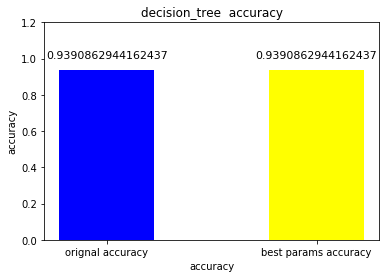

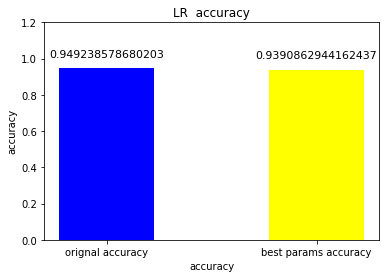

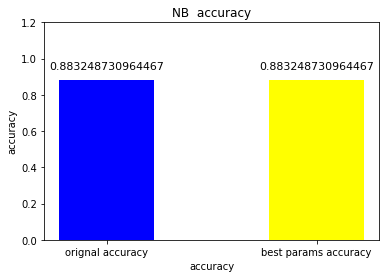

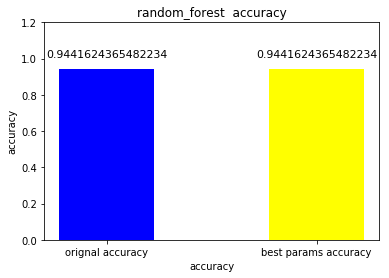

In [13]:
lr_best_predictions=lr_best_model.transform(test_data)
rfc_best_predictions=rfc_best_Model.transform(test_data)
dtc_best_predictions=dtc_best_Model.transform(test_data)
nb_best_predictions=nb_best_Model.transform(test_data)

my_binary_eval = BinaryClassificationEvaluator()

print("DTC_best")
print(my_binary_eval.evaluate(dtc_best_predictions))


print("RFC_best")
print(my_binary_eval.evaluate(rfc_best_predictions))

print("LR_best")
print(my_binary_eval.evaluate(lr_best_predictions))

print("NB_best")
print(my_binary_eval.evaluate(nb_best_predictions))

dtc_acc = acc_evaluator.evaluate(dtc_best_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_best_predictions)
lr_acc = acc_evaluator.evaluate(lr_best_predictions)
nb_acc = acc_evaluator.evaluate(nb_best_predictions)

print('-'*40)
print('A single decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*40)
print('An ensemble using LR has an accuracy of: {0:2.2f}%'.format(lr_acc*100))
print('-'*40)
print('An ensemble using NB has an accuracy of: {0:2.2f}%'.format(nb_acc*100))


def draw_acc_pic(orignal_acc,acc,title):
    plt.figure()
    X = ["orignal accuracy"]  
    XX=["best params accuracy"]  
    Y = [orignal_acc]  
    YY=[acc]  
    #fig = plt.figure()  
    plt.bar(X, Y, 0.45, color="blue")  
    plt.bar(XX,YY,0.45,color="yellow") 
    plt.xlabel("accuracy")  
    plt.ylabel("accuracy")  
    plt.title(title +"  accuracy")
    
    for a,b in zip(X,Y):  
     plt.text(a, b+0.05, b, ha='center', va= 'bottom',fontsize=11)  
    for a,b in zip(XX,YY):  
     plt.text(a, b+0.05, b, ha='center', va= 'bottom',fontsize=11)    
    plt.ylim(0,1.2)    
    plt.show()


draw_acc_pic(dtc_orignal_acc , dtc_acc,"decision_tree")
draw_acc_pic(lr_orignal_acc , lr_acc,"LR")
draw_acc_pic(nb_orignal_acc , nb_acc,"NB")
draw_acc_pic(rfc_orignal_acc , rfc_acc,"random_forest")

####  graded and analyzed best model  graphically

LR model metrics
Area under ROC = 0.980125
Area under PR = 0.976225
[[182.  11.]
 [ 13. 188.]]
[Overall]	precision = 0.9390862944162437 | recall = 0.9390862944162437 | F1 Measure = 0.9390862944162437
[Class 0.0]	precision = 0.9333333333333333 | recall = 0.9430051813471503 | F1 Measure = 0.9381443298969072
[Class 1.0]	precision = 0.9447236180904522 | recall = 0.9353233830845771 | F1 Measure = 0.94


/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:237: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")
/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:249: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")
/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:262: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")


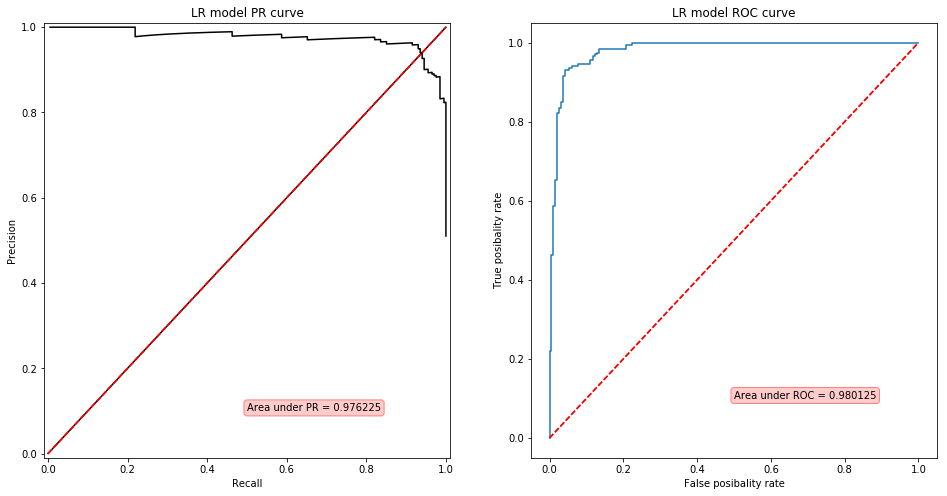

DTC model metrics
Area under ROC = 0.959903
Area under PR = 0.968066
[[176.  17.]
 [  7. 194.]]
[Overall]	precision = 0.9390862944162437 | recall = 0.9390862944162437 | F1 Measure = 0.9390862944162437
[Class 0.0]	precision = 0.9617486338797814 | recall = 0.9119170984455959 | F1 Measure = 0.9361702127659576
[Class 1.0]	precision = 0.919431279620853 | recall = 0.9651741293532339 | F1 Measure = 0.941747572815534


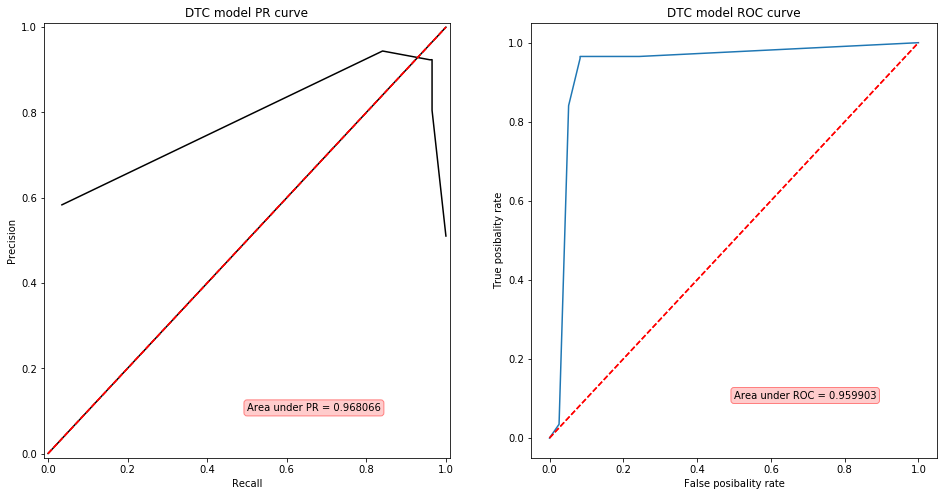

RF model metrics
Area under ROC = 0.981698
Area under PR = 0.977291
[[180.  13.]
 [  9. 192.]]
[Overall]	precision = 0.9441624365482234 | recall = 0.9441624365482234 | F1 Measure = 0.9441624365482234
[Class 0.0]	precision = 0.9523809523809523 | recall = 0.9326424870466321 | F1 Measure = 0.9424083769633508
[Class 1.0]	precision = 0.9365853658536586 | recall = 0.9552238805970149 | F1 Measure = 0.9458128078817735


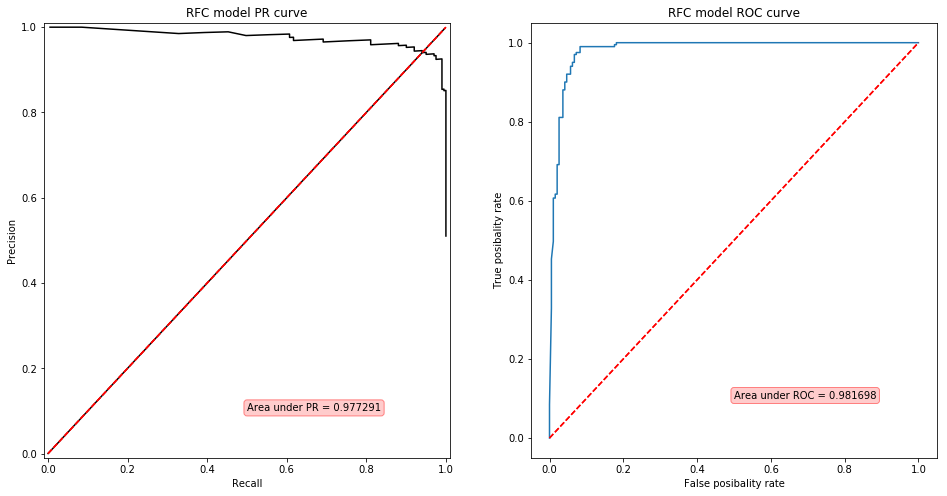

NB model metrics
Area under ROC = 0.178537
Area under PR = 0.348647
[[167.  26.]
 [ 20. 181.]]
[Overall]	precision = 0.883248730964467 | recall = 0.883248730964467 | F1 Measure = 0.883248730964467
[Class 0.0]	precision = 0.893048128342246 | recall = 0.8652849740932642 | F1 Measure = 0.8789473684210526
[Class 1.0]	precision = 0.8743961352657005 | recall = 0.900497512437811 | F1 Measure = 0.8872549019607843


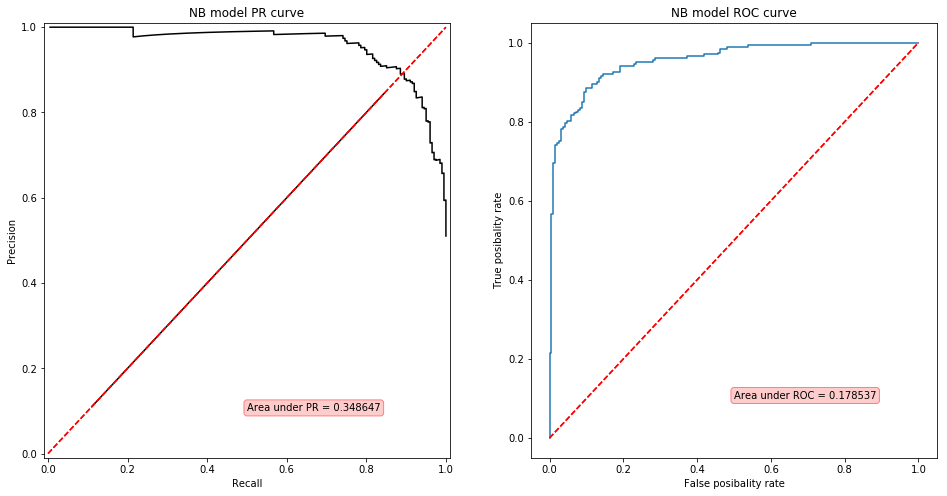

In [14]:
print("LR model metrics")
lr_log = evaluate(lr_best_predictions)

lr_preds = lr_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
lr_roc = CurveMetrics(lr_preds).get_curve('roc')
lr_metrics = CurveMetrics(lr_preds)
lr_f1_score = lr_metrics.get_curve('fMeasureByThreshold')
lr_precision = lr_metrics.get_curve('precisionByThreshold')
lr_recall = lr_metrics.get_curve('recallByThreshold')
lr_under_roc = lr_log['AUROC']
lr_under_pr = lr_log['AUPR']
drawcrue("LR model",lr_roc,lr_recall,lr_precision,lr_under_roc,lr_under_pr)

print("DTC model metrics")
dtc_log = evaluate(dtc_best_predictions)

dtc_preds = dtc_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
dtc_roc = CurveMetrics(dtc_preds).get_curve('roc')
dtc_metrics = CurveMetrics(dtc_preds)
dtc_f1_score = dtc_metrics.get_curve('fMeasureByThreshold')
dtc_precision = dtc_metrics.get_curve('precisionByThreshold')
dtc_recall = dtc_metrics.get_curve('recallByThreshold')

dtc_under_roc = dtc_log['AUROC']
dtc_under_pr = dtc_log['AUPR']
drawcrue("DTC model",dtc_roc,dtc_recall,dtc_precision,dtc_under_roc,dtc_under_pr)

print("RF model metrics")
rfc_log = evaluate(rfc_best_predictions)

rfc_preds = rfc_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rfc_roc = CurveMetrics(rfc_preds).get_curve('roc')
rfc_metrics = CurveMetrics(rfc_preds)
rfc_f1_score = rfc_metrics.get_curve('fMeasureByThreshold')
rfc_precision = rfc_metrics.get_curve('precisionByThreshold')
rfc_recall = rfc_metrics.get_curve('recallByThreshold')

rfc_under_roc = rfc_log['AUROC']
rfc_under_pr = rfc_log['AUPR']
drawcrue("RFC model",rfc_roc,rfc_recall,rfc_precision,rfc_under_roc,rfc_under_pr)
print("NB model metrics")
nb_log = evaluate(nb_best_predictions)

nb_preds = nb_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
nb_roc = CurveMetrics(nb_preds).get_curve('roc')
nb_metrics = CurveMetrics(nb_preds)
nb_f1_score = nb_metrics.get_curve('fMeasureByThreshold')
nb_precision = nb_metrics.get_curve('precisionByThreshold')
nb_recall = nb_metrics.get_curve('recallByThreshold')

nb_under_roc = nb_log['AUROC']
nb_under_pr = nb_log['AUPR']
drawcrue("NB model",nb_roc,nb_recall,nb_precision,nb_under_roc,nb_under_pr)

----------------------------------------
[0.02782313 0.         0.03386796 0.         0.55572406 0.03500615
 0.29265544 0.04524165 0.00144441 0.0082372 ]
 1) F_Undergrad                    0.555724
 2) Outstate                       0.292655
 3) Room_Board                     0.045242
 4) P_Undergrad                    0.035006
 5) Enroll                         0.033868
 6) Apps                           0.027823
 7) perc_alumni                    0.008237
 8) S_F_Ratio                      0.001444
 9) Expend                         0.000000
10) Accept                         0.000000


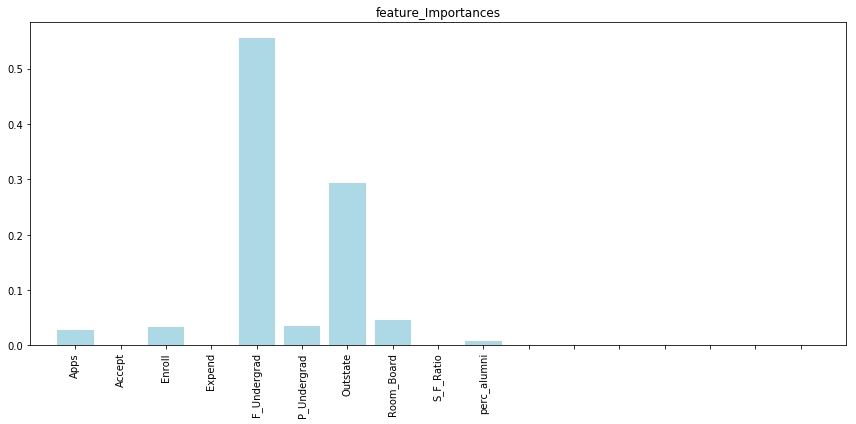

----------------------------------------
[0.03865331 0.06848819 0.10917211 0.02806055 0.24915968 0.05685876
 0.25777499 0.07508545 0.09987786 0.01686909]
 1) Outstate                       0.257775
 2) F_Undergrad                    0.249160
 3) Enroll                         0.109172
 4) S_F_Ratio                      0.099878
 5) Room_Board                     0.075085
 6) Accept                         0.068488
 7) P_Undergrad                    0.056859
 8) Apps                           0.038653
 9) Expend                         0.028061
10) perc_alumni                    0.016869


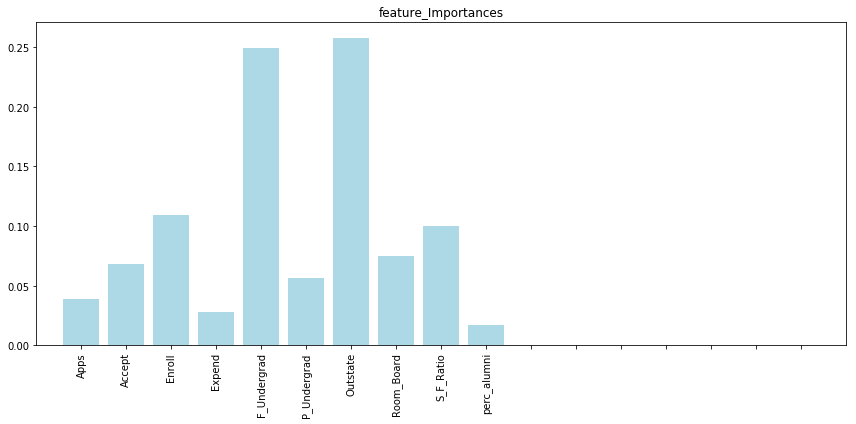

In [15]:

def model_importance_sort(model):
    bestModel = model.bestModel
    feature_Importances = bestModel.stages[-1].featureImportances.toArray()
   
    print(feature_Importances)
   
    sort_index=np.argsort(feature_Importances)[::-1]

    sort_index=sort_index.tolist()
    for f in sort_index:
        print("%2d) %-*s %f" % (sort_index.index(f)+1,30,inputCols[f],feature_Importances[f]))
    plt.figure(figsize=(12,6))
    plt.title("feature_Importances")
    plt.bar(inputCols,
           feature_Importances,
            color="lightblue",
            align="center"
           )
    plt.xticks(range(17),inputCols,rotation='vertical')
    plt.xlim([-1,17])
    plt.tight_layout()
    plt.show()
# model_importance_sort(nb_best_Model)
print('-'*40)
model_importance_sort(dtc_best_Model)
print('-'*40)
model_importance_sort(rfc_best_Model)
